# 1. Descarga y exploración del corpus

# a. Descarga del corpus

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import gzip
import json
import pandas as pd
import os

def load_and_clean_json(path_json, subset_size=4500, desired_cols=['review_text', 'rating'],
                        output_path='/content/drive/MyDrive/Colab Notebooks/PracticaNLP/data/clean_reviews.json'):
    data = []

    # Leer las primeras N líneas del archivo JSON .gz
    with gzip.open(path_json, mode='rt', encoding="utf-8") as my_file:
        for i, line in enumerate(my_file):
            if i >= subset_size:
                break
            item = json.loads(line)
            data.append(item)

    # Convertir a DataFrame completo
    df = pd.DataFrame(data)
    print(f"📊 Total de filas cargadas: {len(df)}")

    # Eliminar duplicados completos
    df = df.drop_duplicates()
    print(f"✅ Filas después de eliminar duplicados: {len(df)}")

    # Filtrar columnas necesarias
    current_cols = [col for col in desired_cols if col in df.columns]
    filtered_df = df[current_cols]

    # Crear carpeta si no existe
    os.makedirs(os.path.dirname(output_path), exist_ok=True)

    # Guardar a JSON accesible por otros scripts
    filtered_df.to_json(output_path, orient='records', force_ascii=False, indent=4)
    print(f"💾 Archivo guardado en: {output_path}")

    return filtered_df


df = load_and_clean_json(
    path_json='/content/drive/MyDrive/Colab Notebooks/PracticaNLP/renttherunway_final_data.json.gz'
)

📊 Total de filas cargadas: 4500
✅ Filas después de eliminar duplicados: 4499
💾 Archivo guardado en: /content/drive/MyDrive/Colab Notebooks/PracticaNLP/data/clean_reviews.json


In [4]:
import pandas as pd
import json
# Cargar el archivo JSON
with open('/content/drive/MyDrive/Colab Notebooks/PracticaNLP/data/clean_reviews.json', mode='r', encoding='utf-8') as file:
    reviews_data = json.load(file)

# Convertir a DataFrame
df = pd.DataFrame(reviews_data)
df.head()

,review_text,rating
0,An adorable romper! Belt and zipper were a lit...,10
1,I rented this dress for a photo shoot. The the...,10
2,This hugged in all the right places! It was a ...,10
3,I rented this for my company's black tie award...,8
4,I have always been petite in my upper body and...,10


# b. Exploración del corpus

Ok, ya está todo el subset (para agilizar el proceso) de todo el dataset guardado y visto que funciona, ahora vamos a inspeccionarlo

In [5]:
# ¿Hay algún valor nulo?
print(df.isnull().values.any())

False


In [6]:
!pip install -U spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 73.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [7]:
df.dtypes

,0
review_text,object
rating,object


In [8]:
from tqdm.notebook import tqdm
import spacy

# is_stop = token es un stop_word
# is_alpha = token tiene caracteres solo (ní simbolos, ni caracteres especiales, etc)
nlp = spacy.load('en_core_web_sm')
def process_text(my_text):
    doc = nlp(my_text.lower().strip())
    return [token.text for token in doc]

# Aplicamos a todo el DataFrame
tqdm.pandas()
df['tokens'] = df['review_text'].progress_apply(process_text)
print(df['tokens'])

0       [an, adorable, romper, !, belt, and, zipper, w...
1       [i, rented, this, dress, for, a, photo, shoot,...
2       [this, hugged, in, all, the, right, places, !,...
3       [i, rented, this, for, my, company, 's, black,...
4       [i, have, always, been, petite, in, my, upper,...
                              ...                        
4494    [the, only, thing, about, the, dress, is, i, w...
4495    [this, dress, was, great, ,, i, ordered, a, 2,...
4496    [true, to, size, ,, comfortable, fit, ,, nice,...
4497    [i, received, so, many, compliments, ., it, ar...
4498    [this, dress, is, very, cute, and, playful, ,,...
Name: tokens, Length: 4499, dtype: object


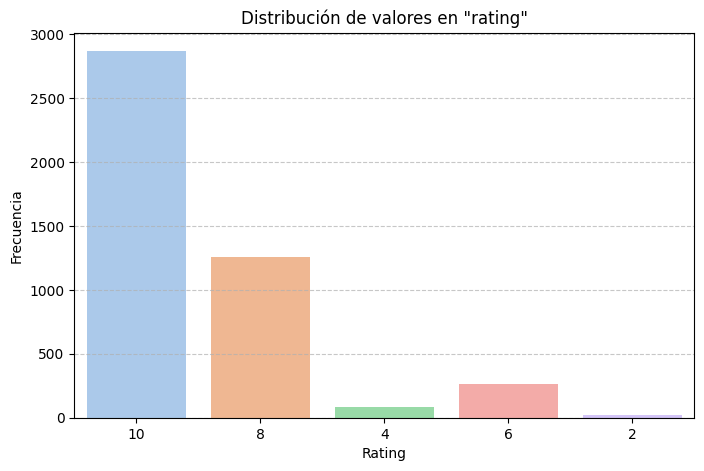

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_distribucion_ratings(df, column='rating'):
    if column not in df.columns:
        print(f"❌ La columna '{column}' no existe en el DataFrame.")
        return

    plt.figure(figsize=(8, 5))
    sns.countplot(x=column, hue=column, data=df, palette='pastel', legend=False)
    plt.title(f'Distribución de valores en "{column}"')
    plt.xlabel(column.capitalize())
    plt.ylabel('Frecuencia')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

plot_distribucion_ratings(df)

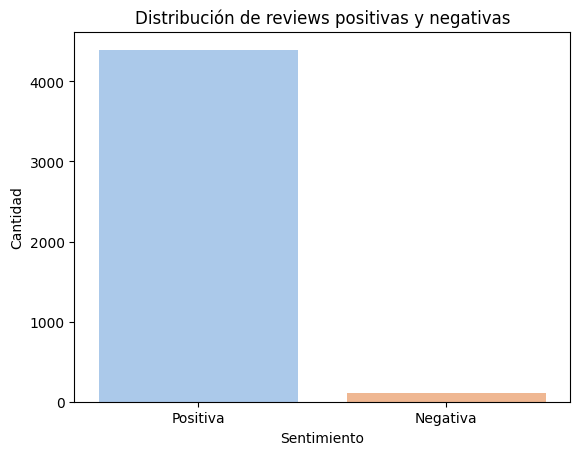

In [10]:
def classify_sentiment(df, col_rating='rating', threshold=5, col_sentiment='sentiment'):
    # Convertir ratings a numérico (float), con manejo de errores
    ratings_float = pd.to_numeric(df[col_rating], errors='coerce')

    # Clasificación binaria del sentimiento
    df[col_sentiment] = ratings_float.apply(lambda x: 'Positiva' if x >= threshold else 'Negativa')

    # Visualización con seaborn
    sns.countplot(x=col_sentiment, hue=col_sentiment, data=df, palette='pastel', legend=False)
    plt.title('Distribución de reviews positivas y negativas')
    plt.xlabel('Sentimiento')
    plt.ylabel('Cantidad')
    plt.show()

    return df

df = classify_sentiment(df)

Ya me lo intuía con el anterior gráfico, pero parece que tenemos un sub dataset desbalanceado en cuanto a opiniones. Confirmaré en los avances a otros ejercicios (habiendo limpiado más el dataset) si hay que balancearlo, aplicando algún tipo de peso restrictivo o menor importancia a las reseñas positivas (sobretodo las de 10 que son las que más hay) para poder crear un modelo más equitativo y justo) o mismamente hacer oversampling a las reseñas negativas o undersampling a las positivas.

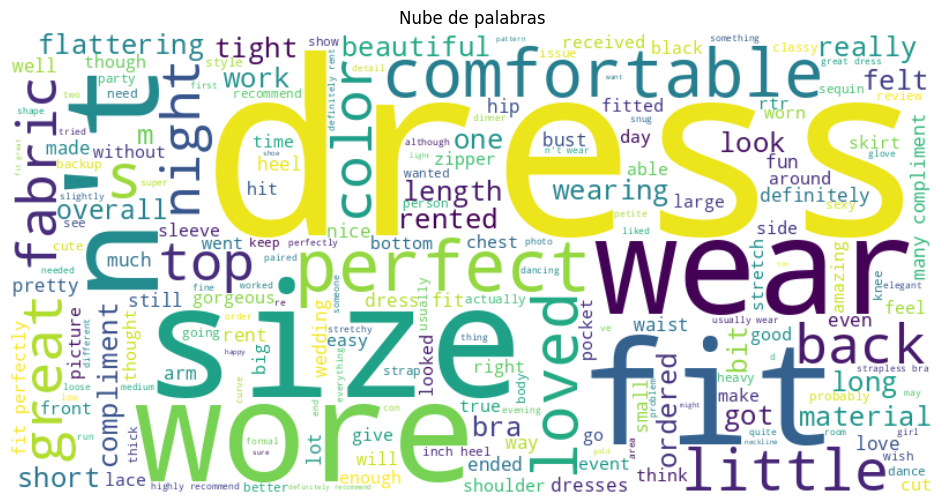

In [11]:
from wordcloud import WordCloud

def generate_cloud_of_words(df, column='tokens', width=800, height=400, background_color='white', max_words=200):
    if column not in df.columns:
        print(f"❌ La columna '{column}' no existe en el DataFrame.")
        return

    # Combinar todas las listas de tokens en un solo string
    all_text = ' '.join([' '.join(tokens) for tokens in df[column]])

    # Crear la nube
    wordcloud = WordCloud(width=width, height=height, background_color=background_color, max_words=max_words).generate(all_text)

    # Mostrar
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Nube de palabras')
    plt.show()

generate_cloud_of_words(df)

Por la nube de palabras, ya se intuye que el tema del sub dataset es moda/ropa, predominantemente femenina. Ciertas palabras como paired o flattering se pueden lematizar, y hay stop_words como s que no aportan nada, hace falta una limpieza.
Beautiful, perfect, great, loved (love), etc, son palabras claves para nuestro análisis de sentimientos, y en una primera instancia, veo que resaltan, describiendo a mi modo de ver el sentimiento positivo predominante en nuestras reviews, tal y como se ve por el dataset, otras, como n't, pueden describir negatividad.